In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
import os.path
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
from sklearn.metrics import classification_report, accuracy_score
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img,img_to_array
print("tf version:", tf.__version__)
import warnings
warnings.filterwarnings('ignore')

tf version: 2.13.0


In [2]:
directory='./Belgium_Datasets'
train_dir=directory+'/BelgiumTSC_Training/Training'
test_dir=directory+'/BelgiumTSC_Testing/Testing'
trainclasses=os.listdir(train_dir)
testclasses=os.listdir(test_dir)

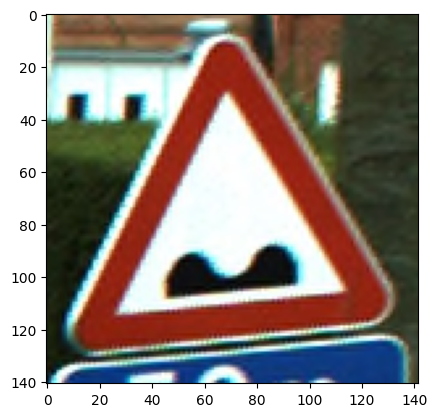

In [8]:
import matplotlib.pyplot as plt
img = load_img('./Belgium_Datasets/BelgiumTSC_Training/Training/00000/01153_00000.ppm')
plt.imshow(img)

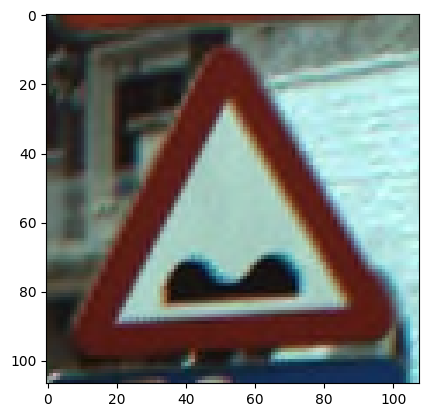

In [10]:
import matplotlib.pyplot as plt
img = load_img('./Belgium_Datasets/BelgiumTSC_Testing/Testing/00000/00017_00000.ppm')
plt.imshow(img)

In [14]:
df=[[]]
df=pd.DataFrame(df)
for i in trainclasses:
    path = "./Belgium_Datasets/BelgiumTSC_Training/Training/"+i+"/GT-"+i+".csv"
    df1 = pd.read_csv(path,sep=';')
    df1['Filename']="./Belgium_Datasets/BelgiumTSC_Training/Training/"+i+'/'+df1["Filename"]
    df=pd.concat([df,df1],ignore_index=True)

df['Rotate']=0
df["length"] = df["Roi.X2"]-df["Roi.X1"]
df["height"] = df["Roi.Y2"]-df["Roi.Y1"]
df=df.dropna()
df.head()
num_of_classes = df["ClassId"].nunique()

In [15]:
df_test=[[]]
df_test=pd.DataFrame(df_test)
for i in trainclasses:
    path = "./Belgium_Datasets/BelgiumTSC_Testing/Testing/"+i+"/GT-"+i+".csv"
    df1 = pd.read_csv(path,sep=';')
    df1['Filename']="./Belgium_Datasets/BelgiumTSC_Testing/Testing/"+i+'/'+df1["Filename"]
    df_test=pd.concat([df_test,df1],ignore_index=True)

df_test['Rotate']=0
df_test["length"] = df_test["Roi.X2"]-df_test["Roi.X1"]
df_test["height"] = df_test["Roi.Y2"]-df_test["Roi.Y1"]
df_test=df_test.dropna()
df_test.head()

,Filename,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Rotate,length,height
1,./Belgium_Datasets/BelgiumTSC_Testing/Testing/...,107.0,108.0,9.0,9.0,98.0,99.0,0.0,0,89.0,90.0
2,./Belgium_Datasets/BelgiumTSC_Testing/Testing/...,94.0,98.0,8.0,8.0,86.0,89.0,0.0,0,78.0,81.0
3,./Belgium_Datasets/BelgiumTSC_Testing/Testing/...,100.0,106.0,8.0,9.0,91.0,96.0,0.0,0,83.0,87.0
4,./Belgium_Datasets/BelgiumTSC_Testing/Testing/...,57.0,61.0,5.0,5.0,51.0,55.0,0.0,0,46.0,50.0
5,./Belgium_Datasets/BelgiumTSC_Testing/Testing/...,59.0,62.0,5.0,5.0,53.0,56.0,0.0,0,48.0,51.0


int32


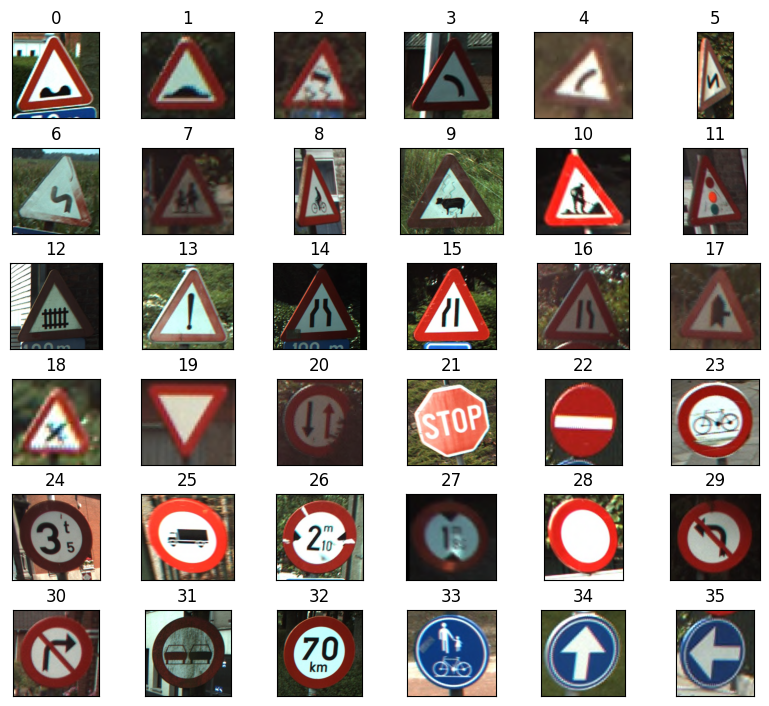

In [23]:
path='./'
df["ClassId"] = df["ClassId"].astype(int)
print(df["ClassId"].dtype)
df_unique = df.copy().drop_duplicates(subset=["ClassId"]).reset_index()

# Display some pictures of the dataset
fig, axes = plt.subplots(nrows=6, ncols=6, figsize=(8, 7),
                        subplot_kw={'xticks': [], 'yticks': []})
# print(df_unique)
for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(path + str(df_unique.Filename[i])))
    ax.set_title(df_unique.ClassId[i], fontsize = 12)
plt.tight_layout(pad=0.5)
plt.show()

In [24]:
import cv2
path='./'
def img_preprocess(df_input):
    X = []  
    for img_path in df_input:
        img = cv2.imread(path + str(img_path))
        
        if img is None:
            print(f"Image cannot be loaded: {img_path}")
            continue 
        
        img = cv2.resize(img, (30, 30))
        
        img = img / 255.0
        
        X.append(img)
    X = np.array(X)  
    return X

In [27]:
X=img_preprocess(df['Filename'])
# print(X)

In [30]:
y=df['ClassId'].to_numpy()
# print(y)

In [31]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=.20,random_state=42)

In [32]:
X_train.shape

(3672, 30, 30, 3)

In [33]:
from tensorflow.keras.layers import Input, Dense, Conv2D, InputLayer, Reshape, MaxPooling2D, Flatten,Dropout, BatchNormalization
from keras.models import Sequential

In [36]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense

model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(30, 30, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(num_of_classes, activation='softmax'))  # 43 kategori

# Modelin derlenmesi
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [37]:
starting_time = time.time()
history=model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=1000,verbose=1)

ending_time = time.time()
total_time = ending_time - starting_time
total_time/=60

print("Time taken fit : ",total_time," min")

Epoch 1/20
115/115 [==============================] - 3s 24ms/step - loss: 2.5453 - accuracy: 0.4412 - val_loss: 1.3440 - val_accuracy: 0.7116
Epoch 2/20
115/115 [==============================] - 3s 27ms/step - loss: 0.8615 - accuracy: 0.7996 - val_loss: 0.5867 - val_accuracy: 0.8716
Epoch 3/20
115/115 [==============================] - 3s 23ms/step - loss: 0.4201 - accuracy: 0.8873 - val_loss: 0.4511 - val_accuracy: 0.8814
Epoch 4/20
115/115 [==============================] - 3s 23ms/step - loss: 0.2443 - accuracy: 0.9346 - val_loss: 0.2899 - val_accuracy: 0.9325
Epoch 5/20
115/115 [==============================] - 3s 24ms/step - loss: 0.1417 - accuracy: 0.9611 - val_loss: 0.2865 - val_accuracy: 0.9304
Epoch 6/20
115/115 [==============================] - 3s 24ms/step - loss: 0.1253 - accuracy: 0.9646 - val_loss: 0.2361 - val_accuracy: 0.9521
Epoch 7/20
115/115 [==============================] - 3s 26ms/step - loss: 0.0803 - accuracy: 0.9771 - val_loss: 0.1795 - val_accuracy: 0.9663

In [38]:
df_test["ClassId"] =df_test["ClassId"].astype(int)
print("Number of Test Images are ", len(df_test))
df_test.dropna()
df_test.head()

Number of Test Images are  2534


,Filename,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Rotate,length,height
1,./Belgium_Datasets/BelgiumTSC_Testing/Testing/...,107.0,108.0,9.0,9.0,98.0,99.0,0,0,89.0,90.0
2,./Belgium_Datasets/BelgiumTSC_Testing/Testing/...,94.0,98.0,8.0,8.0,86.0,89.0,0,0,78.0,81.0
3,./Belgium_Datasets/BelgiumTSC_Testing/Testing/...,100.0,106.0,8.0,9.0,91.0,96.0,0,0,83.0,87.0
4,./Belgium_Datasets/BelgiumTSC_Testing/Testing/...,57.0,61.0,5.0,5.0,51.0,55.0,0,0,46.0,50.0
5,./Belgium_Datasets/BelgiumTSC_Testing/Testing/...,59.0,62.0,5.0,5.0,53.0,56.0,0,0,48.0,51.0


In [40]:
X_test = img_preprocess(df_test["Filename"])

In [41]:
y_test = df_test["ClassId"].values

In [42]:
y_pred = model.predict(X_test)

80/80 [==============================] - 1s 5ms/step


In [43]:
y_pred = np.argmax(y_pred, axis=1)

In [44]:
print(y_pred)

[ 1  1  1 ... 61 61 61]


In [48]:
confusion = confusion_matrix(y_test, y_pred)

# Calculate accuracy
accuracy = np.sum(np.diag(confusion)) / np.sum(confusion)
print("Total Accuracy: ", accuracy*100)


# Calculate precision, recall, and F1-score
classification_rep = classification_report(y_test, y_pred, labels=np.unique(y_pred))

# Print the results
print("\nConfusion Matrix:\n", confusion)


lines = classification_rep.split('\n')
data = []

for line in lines[2:-5]:  # Exclude header and footer lines
    row_data = line.split()
    if len(row_data) > 0:
        class_name = row_data[0]
        precision = float(row_data[1])
        recall = float(row_data[2])
        f1_score = float(row_data[3])
        support = int(row_data[4])
        data.append([class_name, precision, recall, f1_score, support])

# Create a DataFrame
report = pd.DataFrame(data, columns=['Class', 'Precision', 'Recall', 'F1-Score', 'Support'])
# Print the DataFrame
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
print("\n\n\n Summarizing the results : ")
report

Total Accuracy:  92.97553275453828

Confusion Matrix:
 [[  3   3   0 ...   0   0   0]
 [  0  26   0 ...   0   0   0]
 [  0   0   4 ...   0   0   0]
 ...
 [  0   0   0 ...  17   0   0]
 [  0   0   0 ...   0   7   0]
 [  0   0   0 ...   0   0 105]]



 Summarizing the results : 


,Class,Precision,Recall,F1-Score,Support
0,0,0.60,0.50,0.55,6
1,1,0.90,0.96,0.93,27
2,2,1.00,0.57,0.73,7
3,3,0.33,0.17,0.22,6
4,4,0.71,0.83,0.77,12
5,5,1.00,1.00,1.00,3
6,6,0.71,0.83,0.77,6
7,7,0.94,0.91,0.93,90
8,8,0.45,0.75,0.56,12
9,9,0.00,0.00,0.00,0


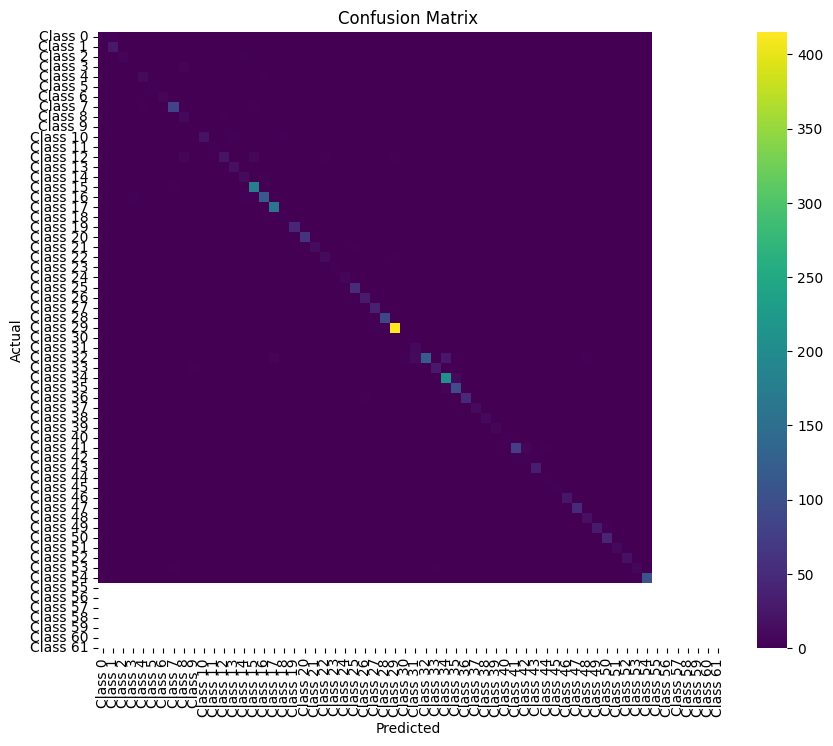

In [49]:
class_names = []
for i in range(num_of_classes):
    class_names.append("Class "+str(i))
# Create a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(confusion, annot=False, cmap="viridis", xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()